In [1]:
# ---- Import libraries ----
import matplotlib.pyplot as plt
from gurobipy import *
import numpy as np
import csv


# ---- Parameters ----

"""Importing the dataset and extracting the appropriate data"""

filename = "data_large_3dep.txt"


with open(filename) as f:
    data = csv.reader(f, delimiter="\t")
    dataset = list(data)

for i in range(0,len(dataset)):
    for j in range(0,7):
        a = int(dataset[i][j])
        dataset[i][j] = a
        
dataset = np.array(dataset)
node_id = dataset[:, 0]  # Stores the id's of the nodes
x_coord = dataset[:, 1]  # Stores the x coordinates of all the nodes
y_coord = dataset[:, 2]  # Stores the y coordinates of all the nodes
a = dataset[:, 3]  # Stores the demand for each node
RT = dataset[:, 4]  # Stores the ready time for each node (earliest time for delivery)
DT = dataset[:, 5]  # Stores the due time for each node (latest time for delivery)
ST = dataset[:, 6]  # Stores the service time for each node (time needed for a delivery at each location )



"""Parameters"""


# Capacities for each vehicle, with the commented out sections being for each case

b = np.array([300 , 300 , 300 , 300 , 300 , 300])  # Case 1
Dc = np.array([5, 0, 0])


# Total number of vehicles
K = len(b)

"""Calculating the Euclidean distance between all nodes """

D = np.zeros((len(a), len(a)))


for i in range(len(node_id)):
    for j in range(len(node_id)):
        Distance = np.linalg.norm((x_coord[i] - x_coord[j], y_coord[i] - y_coord[j]))
        D[i , j] = round(Distance , 2)
        

# Note for this programme, the assumption is made that 1 distance unit corresponds to 1 time unit
# This also allows us to use distance interchangably within constraints with time


# ---- Initialising Model ----

model = Model("Part c/d")


# ---- Sets and Indices ----

I = range(len(node_id))  # locations
J = range(len(node_id))  # locations
depots = range(3)
customers = range(3, len(node_id))
V = range(K)  # vehicles

# ---- Decision Variables ----

"""Initialising the dimensions for all the decision variables"""
x = model.addVars(I, J, V, vtype = GRB.BINARY, name = "If_Route_Travelled")
# z = model.addVars(I, V, vtype = GRB.BINARY, name = "If_Node_Satisfied")
t = model.addVars(I, V, vtype = GRB.CONTINUOUS, name = "Service_Start_Time")
N = model.addVars(range(3) , V ,  vtype = GRB.BINARY, name = "Vehicle_Per_Depot")
    
    
# # ---- Integerate the variables into the model ----
model.update()


# # ---- Objective Function ----
# obj = quicksum(x[i, j, v]*D[i, j] for i in I for j in J for v in V) + 5*N[0]
# model.setObjective(obj, GRB.MINIMIZE)  # Only a function of distance as that is the parameter to minimize

# Objective: Minimize the total distance traveled by all vehicles
objective = quicksum(D[i, j] * x[i, j, v] for i in I for j in J for v in V if i != j)
model.setObjective(objective, GRB.MINIMIZE)


model.update()

# # ---- Constraints ----

M = 3000

# Constraint 1: Each customer is visited exactly once
single_visit = model.addConstrs(
    (quicksum(x[i, j, v] for j in customers for v in V if j != i) + 
     quicksum(x[i, d, v] for d in depots for v in V) == 1 for i in customers),
    "Single_Visit_Satisfaction")



# Constraint 2: Not exceeding the total number of vehicles (assuming you have a variable N[i, v] that counts vehicles at depots)
depot_vehicle_num = model.addConstrs(
    (quicksum(N[i, v] for v in V) <= K for i in depots),
    "Vehicle_Leaving_Depot")


# # Constraint 3: Total number of vehicles used is exactly K
# total_vehicles = model.addConstr(
#     quicksum(N[i, v] for i in depots for v in V) == K,
#     "Total_Vehicles")


# Constraint 4: Vehicle capacity is not exceeded
vehicle_cap = model.addConstrs(
    (quicksum(a[i] * x[i, j, v] for i in customers for j in customers if i != j) +
     quicksum(a[i] * x[i, d, v] for i in customers for d in depots for v in V) <= b[v] for v in V),
    "Vehicle_Capacity")


# Constraint 5: Each vehicle must leave from exactly one depot
unique_depot_start = model.addConstrs(
    (quicksum(x[d, j, v] for d in depots for j in customers) == 1 for v in V),
    "Unique_Depot_Start")


# Constraint 6: Each vehicle must return to a depot
vehicle_return = model.addConstrs(
    (quicksum(x[j, d, v] for d in depots for j in customers) == 1 for v in V),
    "Vehicle_Return_To_Depot")

# Constraint 7: Route continuity (flow conservation)
route_flow_customers = model.addConstrs(
    (quicksum(x[i, j, v] for j in customers if i != j) +
     quicksum(x[i, d, v] for d in depots) - 
     quicksum(x[j, i, v] for j in customers if i != j) -
     quicksum(x[d, i, v] for d in depots) == 0 for i in customers for v in V),
    "Maintaining_Route_Flow_Customers")


route_flow_depots = model.addConstrs(
    (quicksum(x[d, j, v] for j in customers) - 
     quicksum(x[j, d, v] for j in customers) == 0 for d in depots for v in V),
    "Maintaining_Route_Flow_Depots")



# Constraint 8: Service start time is within the ready time and due time
service_start_time = model.addConstrs(
    (t[i, v] >= RT[i] for i in customers for v in V),
    "Service_Start_Not_Before_Ready_Time")

service_end_time = model.addConstrs(
    (t[i, v] <= DT[i] for i in customers for v in V),
    "Service_End_Before_Due_Time")

# Constraint 9: No self return
no_self_return_customers = model.addConstrs(
    (x[i, i, v] == 0 for i in customers for v in V),
    "No_Self_Return_Customers")

no_self_return_depots = model.addConstrs(
    (x[d, d, v] == 0 for d in depots for v in V),
    "No_Self_Return_Depots")


# Constraint 10: Service time window with travel time and service time consideration

customers_list = list(customers)
depots_list = list(depots)

service_time_window_extended = model.addConstrs(
    (t[j, v] >= t[i, v] + ST[i] + D[i, j] - M * (1 - x[i, j, v])
     for i in customers_list + depots_list for j in customers_list for v in V if i != j),
    "Extended_Service_Time_Window")

# Constraint #11: Each vehicle must leave from one of the depots
leave_depot = model.addConstrs(
    (quicksum(x[d, j, v] for d in depots for j in customers if j != d) == 1 for v in V),
    "leave_from_depot")

# Constraint #12: Each vehicle must return to one of the depots
return_depot = model.addConstrs(
    (quicksum(x[j, d, v] for d in depots for j in customers if j != d) == 1 for v in V),
    "return_to_depot")




# Enable detailed output logging
model.setParam("OutputFlag", True)  # Set to True to enable logging

# Set the optimality gap (e.g., 0.05% or 0.0005)
model.setParam("MIPGap", 0.0005)

# Set a time limit for the solver (in seconds, e.g., 1800 seconds)
model.setParam("TimeLimit", 1800)

# Optionally, adjust the heuristic efforts (value between 0 and 1)
# model.setParam("Heuristics", 0.5)

# Update the model to apply the parameters
model.update()

# Now, optimize the model
model.optimize()

# After optimization, you can access the MIPGap
if model.SolCount > 0:
    mip_gap = model.MIPGap
    print("Optimality Gap:", mip_gap)
else:
    print("No solution found or solver did not reach optimality gap within time limit.")




Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-14
Set parameter MIPGap to value 0.0005
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16919 rows, 17190 columns and 120036 nonzeros
Model fingerprint: 0xb584aa9b
Variable types: 318 continuous, 16872 integer (16872 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 7185 rows and 4320 columns
Presolve time: 0.16s
Presolved: 9734 rows, 12870 columns, 79896 nonzeros
Variable types: 300 continuous, 12570 integer (12570 binary)

Root relaxation: objective 2.307900e+02, 746 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Nod

In [2]:
import pandas as pd

In [3]:
def conv(y):
    
    return round(y.x)

In [4]:
pd.DataFrame(np.array(.values()).reshape(len(a), -1)).applymap(conv)

NameError: name 'z' is not defined

In [9]:
df0 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 0]).applymap(conv)
df1 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 1]).applymap(conv)
df2 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 2]).applymap(conv)
df3 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 3]).applymap(conv)
df4 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 4]).applymap(conv)
df5 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 5]).applymap(conv)


route = [[], [], [], [], [], []]

route[0].append(df0[:3].sum(axis=1)[df0[:3].sum(axis=1) == 1].index[0])
route[1].append(df1[:3].sum(axis=1)[df1[:3].sum(axis=1) == 1].index[0])
route[2].append(df2[:3].sum(axis=1)[df2[:3].sum(axis=1) == 1].index[0])
route[3].append(df3[:3].sum(axis=1)[df3[:3].sum(axis=1) == 1].index[0])
route[4].append(df4[:3].sum(axis=1)[df4[:3].sum(axis=1) == 1].index[0])
route[5].append(df5[:3].sum(axis=1)[df5[:3].sum(axis=1) == 1].index[0])

i = 0
while True:
    route[0].append(df0.iloc[route[0][i]][df0.iloc[route[0][i]] == 1].index[0])
    i += 1
    if route[0][i] == route[0][0]:
        break
        
i = 0
while True:
    route[1].append(df1.iloc[route[1][i]][df1.iloc[route[1][i]] == 1].index[0])
    i += 1
    if route[1][i] == route[1][0]:
        break
        
i = 0
while True:
    route[2].append(df2.iloc[route[2][i]][df2.iloc[route[2][i]] == 1].index[0])
    i += 1
    if route[2][i] == route[2][0]:
        break
        
i = 0
while True:
    route[3].append(df3.iloc[route[3][i]][df3.iloc[route[3][i]] == 1].index[0])
    i += 1
    if route[3][i] == route[3][0]:
        break
        
i = 0
while True:
    route[4].append(df4.iloc[route[4][i]][df4.iloc[route[4][i]] == 1].index[0])
    i += 1
    if route[4][i] == route[4][0]:
        break
        
i = 0
while True:
    route[5].append(df5.iloc[route[5][i]][df5.iloc[route[5][i]] == 1].index[0])
    i += 1
    if route[5][i] == route[5][0]:
        break

C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_28896\607120820.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df0 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 0]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_28896\607120820.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 1]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_28896\607120820.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 2]).applymap(conv)
C:\Users\Aditya Pavadad\AppData\Local\Temp\ipykernel_28896\607120820.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df3 = pd.DataFrame(np.array(x.values()).reshape(len(a), len(a), -1)[:, :, 3]).applyma

In [10]:
route

[[1, 34, 35, 33, 37, 39, 40, 41, 38, 36, 1],
 [2, 19, 20, 21, 17, 18, 16, 14, 2],
 [0, 22, 26, 27, 29, 31, 32, 30, 28, 25, 24, 23, 0],
 [0, 7, 5, 9, 10, 12, 13, 11, 8, 6, 4, 3, 0],
 [1, 45, 44, 43, 42, 46, 47, 48, 50, 52, 49, 51, 1],
 [2, 15, 2]]

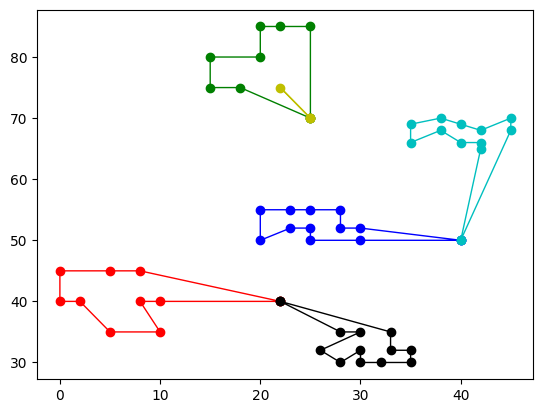

In [12]:
filename = "data_large_3dep.txt"

with open(filename, "r") as file:
    file_content = file.read()



data = []
for line in file_content.split('\n'):
    data.append(line.split())

dat = np.array(data, dtype = 'int')

# route

x_coords = []
y_coords = []
for path in route:
    x_coords.append(dat[path, 1])
    y_coords.append(dat[path, 2])

# x_coords

# y_coords

plt.plot(x_coords[0], y_coords[0], 'ro-', lw = 1);
# plt.plot(x_coords[0][0], y_coords[0][0], 'ko');


plt.plot(x_coords[1], y_coords[1], 'go-', lw = 1);
plt.plot(x_coords[2], y_coords[2], 'bo-', lw = 1);
plt.plot(x_coords[3], y_coords[3], 'co-', lw = 1);
plt.plot(x_coords[4], y_coords[4], 'ko-', lw = 1);
plt.plot(x_coords[5], y_coords[5], 'yo-', lw = 1);
# plt.plot(x_coords[1][0], y_coords[1][0], 'ko');
# plt.plot(x_coords[2][0], y_coords[2][0], 'ko');